# Programming Assignment #4: Recurrent Neural Networks
Author: Pierre Nugues

## Objectives

The objectives of this assignment are to:
* Write a program to recognize named entities in text
* Learn how to manage a text data set
* Apply recurrent neural networks to text
* Know what word embeddings are
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization and location

You can work alone or collaborate with another student:
* Each group will have to write Python programs to recognize named entities in text.
* You will have to experiment different architectures, namely RNN and LSTM, and compare the results you obtained.
* Each student will have to write an individual report on these experiments.

## Imports

In [1]:
import os
import random
import shutil
from tqdm import tqdm

# The machine name
machine_name = 'colab'

# To create the same dataset
random.seed(0)

In [2]:
if machine_name == 'colab':
    from google.colab import drive
    drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
import regex as re
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, Lambda, TimeDistributed
from keras.layers import LSTM, Bidirectional, SimpleRNN, BatchNormalization
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.activations import softmax

EPOCHS = 15
LSTM_UNITS = 100

## Collecting a Dataset

1. You will use a dataset from the CoNLL conferences that benchmark natural language processing systems and tasks. There were two conferences on named entity recognition: <a href="https://www.clips.uantwerpen.be/conll2002/ner/">CoNLL 2002</a> (Spanish and Dutch) and <a href="https://www.clips.uantwerpen.be/conll2003/ner/">CoNLL 2003</a> (English and German). In this assignment, you will work on the English dataset. Read the description of the task.
2. The datasets are protected by a license and you need to obtain it to reconstruct the data. Alternatively, you can try to find one on github (type conll2003 in the search box) or use the Google dataset search: <a href="https://toolbox.google.com/datasetsearch">https://toolbox.google.com/datasetsearch</a>. All this may take time and your teacher created a local copy in the `/usr/local/cs/EDAN95/datasets/NER-data` folder.
3. The dataset comes in the form of three files: a training set, a development set, and a test set. <!--, named:
    <tt>eng.train</tt>, <tt>eng.testa</tt> (validation), and <tt>eng.testb</tt> (test).-->

## Reading the Corpus

You will read the corpus with the cells below. The functions will enable you to load the files in the form of a list of dictionaries.

In [4]:
BASE_DIR = '/content/drive/My Drive/Colab Notebooks/CoNLL2003/'

In [5]:
def load_conll2003_en():
    #train_file = BASE_DIR + 'NER-data/eng.train'
    train_file = BASE_DIR + 'train.txt'
    #dev_file = BASE_DIR + 'NER-data/eng.valid'
    dev_file = BASE_DIR + 'valid.txt'
    #test_file = BASE_DIR + 'NER-data/eng.test'
    test_file = BASE_DIR + 'test.txt'
    column_names = ['form', 'ppos', 'pchunk', 'ner']
    train_sentences = open(train_file, encoding='utf8').read().strip()
    dev_sentences = open(dev_file, encoding='utf8').read().strip()
    test_sentences = open(test_file, encoding='utf8').read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

In [6]:
train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en()
train_sentences[:100]

'-DOCSTART- -X- -X- O\n\nEU NNP B-NP B-ORG\nrejects VBZ B-VP O\nGerman JJ B-NP B-MISC\ncall NN I-NP O\nto T'

In [7]:
class Token(dict):
    pass


class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [8]:
conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

In [9]:
print(train_dict[0])
print('\n'.join(map(str, train_dict[1])))

[{'form': '-DOCSTART-', 'ppos': '-X-', 'pchunk': '-X-', 'ner': 'O'}]
{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-ORG'}
{'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'B-VP', 'ner': 'O'}
{'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}
{'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'}
{'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}
{'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}


In [10]:
print(test_dict[0])
print('\n'.join(map(str, train_dict[1])))

[{'form': '-DOCSTART-', 'ppos': '-X-', 'pchunk': '-X-', 'ner': 'O'}]
{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-ORG'}
{'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'B-VP', 'ner': 'O'}
{'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}
{'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'}
{'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}
{'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}


## Evaluating your Models

You will train the models with the traiing set and the test set to evaluate them. For this, you will apply the `conlleval` script that will compute the harmonic mean of the precision and recall: F1. 

`conlleval` was written in Perl and you have a local copy of this script in `/usr/local/cs/EDAN95/datasets/ner/bin`. Some people rewrote it in Python and you will use such such a translation in this lab. The line below installs it.

In [11]:
#!pip3 install conlleval as conlleval # !: execute the cell as a shell command
%pip install conlleval # %: install into the current kernel
import conlleval

## Collecting the Embeddings

You will represent the words with the GloVe embeddings:
1. Download the GloVe embeddings 6B from <a href="https://nlp.stanford.edu/projects/glove/">https://nlp.stanford.edu/projects/glove/</a> and keep the 100d vectors.
2. You have a local copy of this script in `/usr/local/cs/EDAN95/datasets/`;
3. Apply a function that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embeddings.

In [12]:
embedding_file = '/content/drive/My Drive/Colab Notebooks/glove/glove.6B.100d.txt' 

In [13]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector
    glove.close()
    return embeddings

In [14]:
# We read the embeddings
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))
print('# words in embedding dictionary:', len(embedded_words))

# words in embedding dictionary: 400000


Using a cosine similarity, write a `closest(target_word, embeddings, count=10)` that computes the 5 closest words to the words _table_, _france_, and _sweden_

In [15]:
def closest(target_word, embeddings, count = 10):
    closest_words = {}
    
    # Adding the value of the cosine sim. to the dictionary 
    for word in embeddings:
        closest_words[word] = cosine(embeddings_dict[target_word], embeddings_dict[word])
    
    # Sorting the dictionary and extracting the keys (words)
    closest_words = dict(sorted(closest_words.items(), key=lambda item: item[1])[:count]).keys()
    
    # Return the closests words as a list
    return list(closest_words)

In [16]:
closest('france', embeddings_dict)

['france',
 'belgium',
 'french',
 'britain',
 'spain',
 'paris',
 'germany',
 'italy',
 'europe',
 'netherlands']

## Extracting the $\mathbf{X}$ and $\mathbf{Y}$ Lists of Symbols

Write a `build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True)` function that for each sentence returns the $\mathbf{x}$ and $\mathbf{y}$ lists of symbols consisting of words and NER tags.

In [17]:
def build_sequences(corpus_dict, key_x= 'form', key_y= 'ner', tolower = True):
    X = []
    Y = []
    
    # Iterating through all sentences in corpus
    for sentence in corpus_dict: 
        X_temp_list = []
        Y_temp_list = []
        
        # Iterating through all words in a sentence
        for word in sentence:
            
            if tolower:
                X_temp_list.append(word[key_x].lower())
            else:
                X_temp_list.append(word[key_x])
            
            Y_temp_list.append(word[key_y])
        
        # Appending the lists corresponding to a sentence
        X.append(X_temp_list)
        Y.append(Y_temp_list)  
    
    return X,Y

Apply this function to your datasets so that you create $\mathbf{X}$ and $\mathbf{Y}$ lists of lists consisting of words and NER tags
        
For the second sentence of the training set, you should have:<br/>
<tt>x = ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']</tt><br/>
<tt>y = ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']</tt><br/>
Some datasets you may find on the web use a different NER tagset, where <tt>I-</tt> is
replaced with <tt>B-</tt>, like <tt>B-ORG</tt> instead of <tt>I-ORG</tt>. This will not change the results.

In [18]:
X, Y = build_sequences(train_dict, key_x='form', key_y='ner')
print('First sentence, words', X[1])
print('First sentence, NER', Y[1])

First sentence, words ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
First sentence, NER ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


## Vocabulary

Create a vocabulary of all the words observed in the training set and the words in GloVe. You should find 402,595 different words. You will proceed in two steps.

First extract the list of unique words from the CoNLL training set and the list of tags. You will sort them

In [19]:
def vocabulary_creator(X,Y):
    words = []
    ner = []

    # Iterating through the X and Y list
    for sentence_words, sentence_tags in zip(X,Y):
    
        # Iterating through the word and tag list
        for word,tag  in zip(sentence_words,sentence_tags):
        
            # Appending word and its tag if it is not there already
            if word not in words:
                words.append(word)
                ner.append(tag)

    # Extracting the unique tags and sort
    ner = sorted(np.unique(ner))
    words = sorted(words)
    
    return ner, words

In [20]:
ner, words = vocabulary_creator(X,Y)

In [21]:
print('# words seen in training corpus:', len(words))
print('# NER tags seen:', len(ner))

# words seen in training corpus: 21010
# NER tags seen: 9


Then merge the list of unique CoNLL words with the words in the embedding file. You will sort this list

In [22]:
vocabulary_words = sorted(np.unique(list(embeddings_dict.keys()) + words))

In [23]:
print('# words in the vocabulary: embeddings and corpus:', len(vocabulary_words))

# words in the vocabulary: embeddings and corpus: 402595


## Index

Create indices `word2idx`, `ner2idx` and inverted indices `idx2word`, `idx2ner` for the words and the NER: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words.

In [24]:
word2idx = dict(zip(vocabulary_words, list(range(2,len(vocabulary_words)+2))))
idx2word = dict(zip(list(range(2,len(vocabulary_words)+2)),vocabulary_words ))
ner2idx = dict(zip(ner, list(range(2,len(ner)+2))))
idx2ner = dict(zip(list(range(2,len(ner)+2)),ner ))

In [25]:
print('word index:', list(word2idx.items())[:25])
print('index word:', list(idx2word.items())[:25])
print('NER index:', list(ner2idx.items())[:25])
print('index word:', list(idx2ner.items())[:25])

word index: [('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11), ('###', 12), ('#a', 13), ('#aabccc', 14), ('#b', 15), ('#c', 16), ('#cc', 17), ('#ccc', 18), ('#cccccc', 19), ('#ccccff', 20), ('#d', 21), ('#daa', 22), ('#dcdcdc', 23), ('#e', 24), ('#f', 25), ('#faf', 26)]
index word: [(2, '!'), (3, '!!'), (4, '!!!'), (5, '!!!!'), (6, '!!!!!'), (7, '!?'), (8, '!?!'), (9, '"'), (10, '#'), (11, '##'), (12, '###'), (13, '#a'), (14, '#aabccc'), (15, '#b'), (16, '#c'), (17, '#cc'), (18, '#ccc'), (19, '#cccccc'), (20, '#ccccff'), (21, '#d'), (22, '#daa'), (23, '#dcdcdc'), (24, '#e'), (25, '#f'), (26, '#faf')]
NER index: [('B-LOC', 2), ('B-MISC', 3), ('B-ORG', 4), ('B-PER', 5), ('I-LOC', 6), ('I-MISC', 7), ('I-ORG', 8), ('I-PER', 9), ('O', 10)]
index word: [(2, 'B-LOC'), (3, 'B-MISC'), (4, 'B-ORG'), (5, 'B-PER'), (6, 'I-LOC'), (7, 'I-MISC'), (8, 'I-ORG'), (9, 'I-PER'), (10, 'O')]


## Embedding Matrix

Create a matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary. The shape of your matrix should be: (402597, 100). Initialize it with random values.

In [29]:
embedding_matrix = np.random.rand(len(vocabulary_words)+2, len(list(embeddings_dict.values())[0]))

In [30]:

print('Shape of embedding matrix:', embedding_matrix.shape)

Shape of embedding matrix: (402597, 100)


Fill the matrix with the GloVe embeddings when available. You will use the indices from the previous section. You will call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [31]:
out_of_embeddings = []

# Iterating through all words in vocabulary
for word in vocabulary_words:
    
# If the word has a glove embedding the row is updated
  if word in embeddings_dict.keys():
    embedding_matrix[word2idx[word]] = embeddings_dict[word]
    
# If the word does not have a glove embedding we append the word to a list
  else:
    out_of_embeddings.append(word)
    

In [32]:
print('Out of embeddings:', len(out_of_embeddings))
out_of_embeddings[-10:]

Out of embeddings: 2595


['zelezarny',
 'zhilan',
 'zieger',
 'zighayer',
 'zilinskiene',
 'zirka-nibas',
 'zuleeg',
 'zundra',
 'zwingmann',
 'zyrecha']

In [33]:
print('Embedding of the padding symbol, idx 0, random numbers', embedding_matrix[0][:10])
print('Embedding of table', embedding_matrix[word2idx['table']][:10])
print('Embedding of zwingmann, random numbers', embedding_matrix[word2idx['zwingmann']][:10])

Embedding of the padding symbol, idx 0, random numbers [0.00969405 0.12740081 0.93836284 0.75829851 0.08821553 0.92349729
 0.97158182 0.30208494 0.33986151 0.19973092]
Embedding of table [-0.61453998  0.89692998  0.56770998  0.39102    -0.22437     0.49035001
  0.10868     0.27410999 -0.23833001 -0.52152997]
Embedding of zwingmann, random numbers [0.53884162 0.64917366 0.47327194 0.59612637 0.77124694 0.44301748
 0.71021769 0.55200232 0.67369865 0.76049915]


## Creating the $\mathbf{X}$ and $\mathbf{Y}$ Sequences

You will now create the input and output sequences with numerical indices. First, convert the $\mathbf{X}$ and $\mathbf{Y}$ lists of symbols in lists of numbers using the indices you created

In [34]:
def XY_idx(X,Y, word2idx, ner2idx):
    
    X_idx = []
    Y_idx = []

    # Iterating through all sentences (both repr. by words and tags)
    for sentence_words, sentence_tags in zip(X,Y):
        X_idx_temp = []
        Y_idx_temp = []
    
        # Iterating through the actual words and tags
        for word, tag in zip(sentence_words, sentence_tags):
        
            # Appending the word's index and the belonging tag index
            X_idx_temp.append(word2idx[word])
            Y_idx_temp.append(ner2idx[tag])
    
        X_idx.append(X_idx_temp)
        Y_idx.append(Y_idx_temp)
    
    return X_idx, Y_idx

In [35]:
X_idx, Y_idx = XY_idx(X,Y,word2idx, ner2idx)
print('First sentences, word indices', X_idx[:3])
print('First sentences, POS indices', Y_idx[:3])

First sentences, word indices [[935], [142143, 307143, 161836, 91321, 363368, 83766, 85852, 218260, 936], [284434, 79019]]
First sentences, POS indices [[10], [4, 10, 3, 10, 10, 10, 3, 10, 10], [5, 9]]


Pad the sentences using the <tt>pad_sequences</tt> function. As maximum length and `maxlen` argument, you will use 150 or greater. What matters is that you have a length that is larger than the maximum length observed in your training and development corpora. After padding, the second sentence you look like (the indices are not necessarily the same).
```
x = [     0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0 142143 307143 161836  91321 363368  83766  85852 218260    936]
y = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 9 6 9 9 9 6
9 9]
```

In [36]:
X_train,Y_train = pad_sequences(X_idx, maxlen = 150), pad_sequences(Y_idx, maxlen = 150)


In [37]:
print(X_train[1])
print(Y_train[1])

[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      

In [38]:
# FUndering: nu låter jag alla paddings få [1.,0., ...., 0.] och inte bara nollor, men sambergs gjorde inte så

def y_creator(Y):
    y = []

    # Iterating through all sentences
    for sentence in Y:
        y_sentence_temp = []
    
        # Iterating through all words in the sentence
        for i in range(len(sentence)):
            idx_list = list(np.zeros(11))
        
            if sentence[i] != float(0):
            
                # Appending the index sentence[i]
                idx_list[sentence[i]] = 1.
                y_sentence_temp.append(idx_list)
            
            else:
                # Appending zero-array with 1 on index 0 if we have padding
                idx_list[0] = 1.
                y_sentence_temp.append(idx_list)
        
        # Appending the list of lists for the sentence as a numpy array    
        y.append(np.array(y_sentence_temp))
    
    return np.array(y)
        


In [39]:
y_train = y_creator(Y_train)

In [40]:
y_train[1][-15:]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Do the same for the development set: Build the sequences, map them to indices, pad them, and create $\mathbf{Y}$ vectors

In [41]:
print(X_train[1])

[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      

In [42]:
X_dev, Y_dev = build_sequences(dev_dict, key_x='form', key_y='ner')
print('First sentence, words', X_dev[1])
print('First sentence, NER', Y_dev[1])

First sentence, words ['cricket', '-', 'leicestershire', 'take', 'over', 'at', 'top', 'after', 'innings', 'victory', '.']
First sentence, NER ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [44]:
# Change all words to indices
# Iterating through all sentences
X_dev_idx = []
Y_dev_idx = []
for sentence_words, sentence_tags in zip(X_dev, Y_dev):
  X_temp = []
  Y_temp = []

  #Iterating through all words
  for word,tag in zip(sentence_words, sentence_tags):
    

    # If the word exists in word2idx the word is changed to the index
    if word in word2idx:
      X_temp.append(word2idx[word])
      Y_temp.append(ner2idx[tag])
      
    # If the word is unknown it is given the index 1
    else:
      X_temp.append(1)
      Y_temp.append(1)

  X_dev_idx.append(X_temp)
  Y_dev_idx.append(Y_temp)


In [45]:
print(X_dev_idx[:5])
print(Y_dev_idx[:5])

[[935], [113351, 679, 221875, 354360, 275584, 63471, 364505, 49150, 192163, 381011, 936], [227217, 15431], [388337, 190955, 53074, 285387, 334414, 364408, 154113, 153033, 26724, 271939, 155673, 62067, 221875, 72732, 339658, 89620, 55656, 192163, 56102, 27037, 315734, 190291, 370791, 119532, 363368, 354360, 275584, 63471, 359698, 176975, 270183, 359698, 112003, 98068, 936], [359787, 344567, 271939, 364505, 517, 360899, 517, 239396, 72525, 332083, 62067, 363053, 311620, 141543, 517, 122982, 56102, 350973, 52957, 104593, 190291, 271939, 381011, 389041, 207175, 231815, 375805, 153033, 227942, 362338, 190291, 359787, 301687, 238429, 49241, 266809, 936]]
[[10], [10, 10, 4, 10, 10, 10, 10, 10, 10, 10, 10], [2, 10], [3, 7, 10, 5, 9, 10, 10, 10, 10, 10, 10, 10, 4, 10, 4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 10, 4, 10, 4, 10, 10, 10, 10, 10, 10, 4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 10]]


In [46]:
X_dev_padded, Y_dev_padded = pad_sequences(X_dev_idx, maxlen = 150), pad_sequences(Y_dev_idx, maxlen = 150)

In [47]:
y_dev = []

# Iterating through all sentences
for sentence in Y_dev_padded:
  y_sentence_temp = []

  # Iterating through all words in the sentence
  for i in range(len(sentence)):
    idx_list = list(np.zeros(11))

    if sentence[i] != float(0):

      # Appending the index sentence[i]
      idx_list[sentence[i]] = 1.
      y_sentence_temp.append(idx_list)

    else:
      # Appending zero-array with 1 on index 0 if we have padding
      idx_list[0] = 1.
      y_sentence_temp.append(idx_list)

  # Appending the list of lists for the sentence as a numpy array  
  y_dev.append(np.array(y_sentence_temp))

y_dev = np.array(y_dev)

## Building a Simple Recurrent Neural Network

Create a simple recurrent network and train a model with the training set. As layers, you will use `Embedding`, `SimpleRNN`, and `Dense`.

In [48]:
max_features = len(vocabulary_words)+2 # Length of vocabulary including tag for padding and unknown words
arraylen = 100
max_len = 150

In [49]:
# ORIGINAL 
model = Sequential()
model.add(Embedding(max_features, arraylen, input_length = max_len, weights = [embedding_matrix], trainable = False, mask_zero = True))
model.add(SimpleRNN(return_sequences=True, units = LSTM_UNITS))
model.add(Dense(11, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          40259700  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 150, 100)          20100     
_________________________________________________________________
dense (Dense)                (None, 150, 11)           1111      
Total params: 40,280,911
Trainable params: 21,211
Non-trainable params: 40,259,700
_________________________________________________________________


In [ ]:
# IMPROVED

model = Sequential()
model.add(Embedding(max_features, arraylen, input_length = max_len, weights = [embedding_matrix], trainable = False, mask_zero = True))
#model.add(Bidirectional(LSTM(100, return_sequences=True))) # second eval, adding this layer
model.add(Bidirectional(layer = SimpleRNN(return_sequences=True, units = LSTM_UNITS)))
model.add(Dropout(0.2)) #  second eval, adding this layer
model.add(SimpleRNN(return_sequences=True, units = LSTM_UNITS))
model.add(Dropout(0.2)) # second eval, adding this layer
model.add(SimpleRNN(return_sequences=True, units = LSTM_UNITS)) # second eval, adding this layer again
model.add(Dense(11, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          40259700  
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 200)          40200     
_________________________________________________________________
dropout (Dropout)            (None, 150, 200)          0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 150, 100)          30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 150, 100)          20100     
_________________________________________________________________
dense_1 (Dense)              (None, 150, 11)          

Compile your network. 

Fit it

In [50]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [51]:
history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=32, validation_data=(X_dev_padded, y_dev))

Epoch 1/15
469/469 [==============================] - 86s 183ms/step - loss: 0.0283 - acc: 0.9142 - val_loss: 0.0346 - val_acc: 0.9268
Epoch 2/15
469/469 [==============================] - 86s 183ms/step - loss: 0.0180 - acc: 0.9438 - val_loss: 0.0368 - val_acc: 0.9353
Epoch 3/15
469/469 [==============================] - 85s 181ms/step - loss: 0.0154 - acc: 0.9513 - val_loss: 0.0369 - val_acc: 0.9406
Epoch 4/15
469/469 [==============================] - 87s 186ms/step - loss: 0.0137 - acc: 0.9558 - val_loss: 0.0367 - val_acc: 0.9427
Epoch 5/15
469/469 [==============================] - 87s 185ms/step - loss: 0.0125 - acc: 0.9593 - val_loss: 0.0360 - val_acc: 0.9447
Epoch 6/15
469/469 [==============================] - 87s 186ms/step - loss: 0.0116 - acc: 0.9622 - val_loss: 0.0369 - val_acc: 0.9444
Epoch 7/15
469/469 [==============================] - 87s 187ms/step - loss: 0.0109 - acc: 0.9643 - val_loss: 0.0354 - val_acc: 0.9484
Epoch 8/15
469/469 [==============================] - 8

Create a figure to show the training and validation losses and accuracies and comment on a possible overfit.

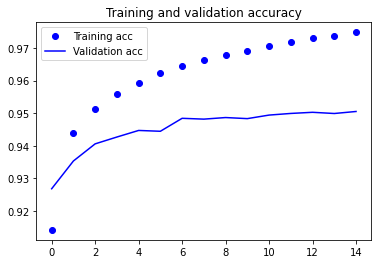

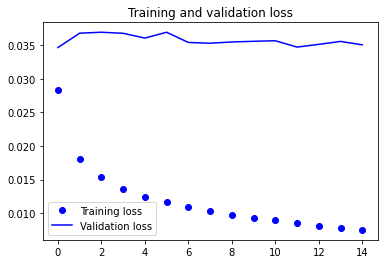

In [52]:
# ORIGINAL
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

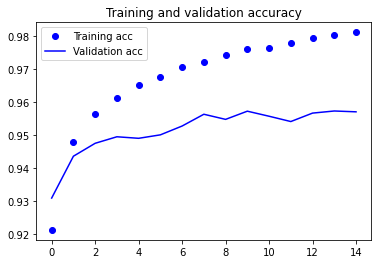

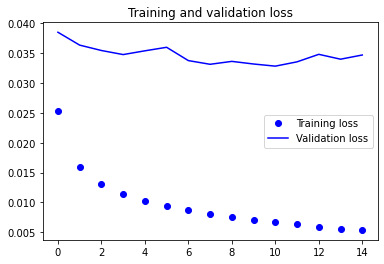

In [ ]:
# IMPROVED
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Apply your network to one sentence.

In [53]:
sentence = 'The United States might collapsez'.lower().split()

First convert the sentence into indices

In [54]:
# Write your code
word_indices = []
for word in sentence:
    if word in list(word2idx.keys()):
        word_indices.append(word2idx[word])
    else:
        word_indices.append(1)

In [55]:
print('Sentence ', sentence)
print('Sentence word indexes ', word_indices)

Sentence  ['the', 'united', 'states', 'might', 'collapsez']
Sentence word indexes  [359698, 374678, 344404, 246008, 1]


In [56]:
x_sentence = pad_sequences([word_indices], maxlen = 150)

Apply the prediction

In [57]:
predictions = model.predict_classes(x_sentence)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [58]:
for i in range(len(sentence)):
  print(sentence[i], ':', idx2ner[predictions[0][i-len(sentence)]])

the : O
united : B-LOC
states : I-LOC
might : O
collapsez : O


## Evaluating your System

You will now evaluate the performance of your system on the whole test set. You will use the official script.
<ol>
    <li>Use the <tt>predict</tt> method to predict the tags of the whole test set
    </li>
    <li>Write your results in a file, where the two last columns will be the hand-annotated tag
        and the predicted tag. The fields must be separated by a space and each line must end with a new line:
        <tt>\n</tt>.
    </li>
    <li>
        If you save your results on a Windows machine, Python will use the default end-of-line sequence: <tt>\r\n</tt>.
        You will then need either to convert your file or to modify the way you save your file.
    </li>
    <li>Apply <tt>conlleval</tt> to your output. Report the F1 result.<br/>
        Be aware that <tt>conlleval</tt> was designed for Unix and will break
    with Windows end-of-line conventions.</li>
    <li>Try to improve your model by modifying some parameters, adding layers, adding
        <tt>Bidirectional</tt>
        and <tt>Dropout</tt>.
    </li>
    <li>
        Evaluate your network again
    </li>
</ol>

First translate the input part of the test set, the words, into lists of words, `X_test`, lists of indices, `X_test_idx`, and a matrix of indices, where you will pad the sequences: `X_test_padded`

In [59]:
# Test
X_test, Y_test = build_sequences(test_dict, key_x='form', key_y='ner')
print('X_test:', X_test[1])
print('Y_test', Y_test[1])

X_test: ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']
Y_test ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']


In [60]:
# Write your code
X_test_idx = []

for sentence in X_test:
  X_idx_temp = []

  for word in sentence:

    if word in word2idx:
      X_idx_temp.append(word2idx[word])
    
    else:
      X_idx_temp.append(1)
  
  X_test_idx.append(X_idx_temp)


In [61]:
X_test_padded = pad_sequences(X_test_idx, maxlen = 150)

In [62]:
print('X_test_idx:', X_test_idx[1])
print('X_test_padded:', X_test_padded[1])

X_test_idx: [338644, 679, 197600, 162137, 229067, 390518, 517, 100680, 190291, 350949, 120818, 936]
X_test_padded: [     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0     

In [63]:
X_test_padded.shape

(3684, 150)

Now predict the whole test set with `predict` and set the results in `Y_test_hat`

In [64]:
# Write your code
Y_test_hat = model.predict(X_test_padded)
Y_test_hat_class = np.argmax(Y_test_hat , axis = -1)

In [65]:
print('X_test', X_test[1])
print('X_test_padded', X_test_padded[1])
print('Predictions', Y_test_hat[0])
print('Predictions', Y_test_hat_class[0])

X_test ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']
X_test_padded [     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0    

Extract the indices of the highest probabilities from the lists and convert them into NER values. Add them with the `pner` key to the dictionaries in the `test_dict` list.

In [66]:
for i, sentence in enumerate(test_dict,0):

  for j, word in enumerate(sentence,0):
    word['pner'] = idx2ner[Y_test_hat_class[i][j-len(sentence)]]


In [67]:
ARCH = '1'
outfile = 'test' + ARCH + '.out'

In [68]:
column_names = ['form', 'ppos', 'pchunk', 'ner', 'pner']

In [69]:
def save(file, corpus_dict, column_names):
    """
    Saves the corpus in a file
    :param file:
    :param corpus_dict:
    :param column_names:
    :return:
    """
    i = 0
    with open(file, 'w', encoding='utf8') as f_out:
        i += 1
        for sentence in corpus_dict:
            sentence_lst = []
            for row in sentence:
                items = map(lambda x: row.get(x, '_'), column_names)
                sentence_lst += ' '.join(items) + '\n'
            sentence_lst += '\n'
            f_out.write(''.join(sentence_lst))

In [70]:
file = '/content/drive/My Drive/Colab Notebooks/' + outfile

In [71]:
save(file, test_dict, column_names)

In [72]:
lines = open(file, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
baseline_score = res['overall']['chunks']['evals']['f1']
baseline_score

0.7408634976013956

## Building a LSTM Network

1. Create a simple LSTM network and train a model with the train set. As layers, you will use <tt>Embedding</tt>, <tt>LSTM</tt>, and <tt>Dense</tt>.
2. Apply conlleval to your output. Report the F1 result.
3. Try to improve your model by modifying some parameters, adding layers, adding <tt>Bidirectional</tt>, <tt>Dropout</tt>, possibly mixing <tt>SimpleRNN</tt>.
4. Apply your network to the test set and report the accuracy you obtained. you need to reach a F1 of 82 to pass.

In [ ]:
# ORIGINAL MODEL
model2 = Sequential()
model2.add(Embedding(max_features, arraylen, input_length = max_len, weights = [embedding_matrix], trainable = False, mask_zero = True))
model2.add(LSTM(32, return_sequences=True))
model2.add(Dense(11, activation = 'softmax'))
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 150, 100)          40259700  
_________________________________________________________________
lstm_5 (LSTM)                (None, 150, 32)           17024     
_________________________________________________________________
dense_7 (Dense)              (None, 150, 11)           363       
Total params: 40,277,087
Trainable params: 17,387
Non-trainable params: 40,259,700
_________________________________________________________________


In [73]:
# IMPROVED
model2 = Sequential()
model2.add(Embedding(max_features, arraylen, input_length = max_len, weights = [embedding_matrix], trainable = False, mask_zero = True))
model2.add(Dropout(0.2)) # Improving the model by adding this
model2.add(Bidirectional(LSTM(100, return_sequences=True))) # Improving the model by adding this
model2.add(Dropout(0.2))# Improving the model by adding this
model2.add(Dense(11, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          40259700  
_________________________________________________________________
dropout (Dropout)            (None, 150, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 200)          160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 200)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 150, 11)           2211      
Total params: 40,422,711
Trainable params: 163,011
Non-trainable params: 40,259,700
_________________________________________________________________


In [74]:
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [75]:
history = model2.fit(X_train, y_train,
                    epochs=15,
                    batch_size=32, validation_data=(X_dev_padded, y_dev))

Epoch 1/15
469/469 [==============================] - 277s 590ms/step - loss: 0.0301 - acc: 0.9080 - val_loss: 0.0341 - val_acc: 0.9367
Epoch 2/15
469/469 [==============================] - 262s 559ms/step - loss: 0.0159 - acc: 0.9488 - val_loss: 0.0318 - val_acc: 0.9509
Epoch 3/15
469/469 [==============================] - 261s 556ms/step - loss: 0.0127 - acc: 0.9584 - val_loss: 0.0320 - val_acc: 0.9547
Epoch 4/15
469/469 [==============================] - 259s 553ms/step - loss: 0.0109 - acc: 0.9641 - val_loss: 0.0311 - val_acc: 0.9579
Epoch 5/15
469/469 [==============================] - 259s 552ms/step - loss: 0.0098 - acc: 0.9677 - val_loss: 0.0312 - val_acc: 0.9588
Epoch 6/15
469/469 [==============================] - 258s 551ms/step - loss: 0.0088 - acc: 0.9705 - val_loss: 0.0303 - val_acc: 0.9615
Epoch 7/15
469/469 [==============================] - 259s 551ms/step - loss: 0.0081 - acc: 0.9731 - val_loss: 0.0301 - val_acc: 0.9619
Epoch 8/15
469/469 [============================

Compile and fit it

Create a figure to show the training and validation losses and accuracies and comment on a possible overfit.

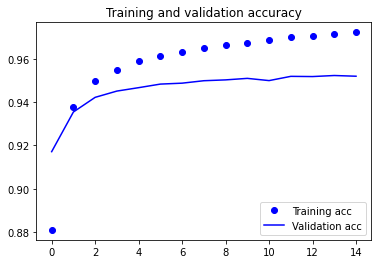

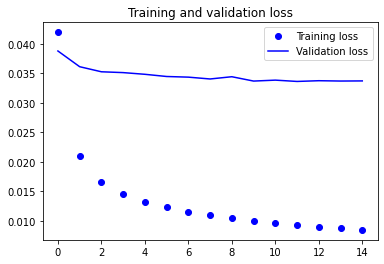

In [ ]:
#ORIGINAL
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

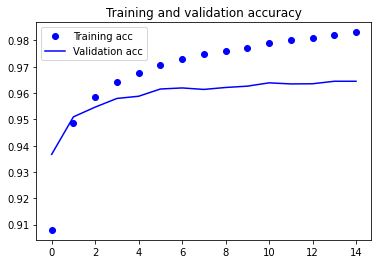

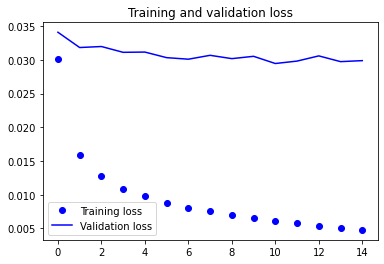

In [76]:
#IMPROVED
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Predict the NER sequence

In [77]:
# Test
X_test, Y_test = build_sequences(test_dict, key_x='form', key_y='ner')
print('X_test:', X_test[1])
print('Y_test', Y_test[1])

X_test: ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']
Y_test ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']


In [78]:
X_test_idx = []

for sentence in X_test:
  X_idx_temp = []

  for word in sentence:

    if word in word2idx:
      X_idx_temp.append(word2idx[word])
    
    else:
      X_idx_temp.append(1)
  
  X_test_idx.append(X_idx_temp)

X_test_padded = pad_sequences(X_test_idx, maxlen = 150)


In [79]:
Y_test_hat = model2.predict(X_test_padded)
Y_test_hat_class = np.argmax(Y_test_hat , axis = -1)

Extract the indices of the highest probabilities from the lists and convert them into NER values. Add them with the `pner` key to the dictionaries in the `test_dict` list.

In [80]:
Y_test_hat_class[10]

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  2, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  2, 10])

In [81]:
for i, sentence in enumerate(test_dict,0):

  for j, word in enumerate(sentence,0):
    word['pner'] = idx2ner[Y_test_hat_class[i][j-len(sentence)]]


In [82]:
ARCH = '4'
outfile = 'test' + ARCH + '.out'

In [83]:
save(outfile, test_dict, column_names)

In [85]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
improved_score = res['overall']['chunks']['evals']['f1']
improved_score

0.8464115676247576

You need to reach 82 to pass the assignment.